In [1]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('./data/sksolartimevariation5804d.txt', skiprows=13, sep='\s+', names=['t_mean(s)', 't_mean-t_start(s)', 't_end-t_mean(s)', 'nu_flux(1e6cm-2s-1)', 'flux_up_error(1e6cm-2s-1)', 'flux_down_error(1e6cm-2s-1)'])
data

,t_mean(s),t_mean-t_start(s),t_end-t_mean(s),nu_flux(1e6cm-2s-1),flux_up_error(1e6cm-2s-1),flux_down_error(1e6cm-2s-1)
0,833654760,170100,277380,2.74,0.63,0.53
1,834127080,175500,210060,2.83,0.75,0.62
2,834550800,213180,230160,2.30,0.53,0.45
3,834997020,199380,212640,1.79,0.55,0.44
4,835380420,170520,265680,3.15,0.74,0.61
...,...,...,...,...,...,...
1338,1525315550,172739,172774,2.36,0.36,0.33
1339,1525703838,215064,215054,2.26,0.31,0.29
1340,1526138206,216970,216028,1.88,0.33,0.29
1341,1526588224,232102,226109,1.90,0.38,0.28


date_to_calculate = "2024-02-14"
observer_location = EarthLocation(lat=-90*un.deg, lon=0*un.deg, height=0*un.m)

observation_time = time.Time(date_to_calculate)
with solar_system_ephemeris.set('builtin'):
    sun_position = get_sun(observation_time)

sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

distance = sun_altaz.distance
print(distance)


Still can you divide each bin into about 5 sub-bins \
and calculate the distance in each bin and take the average\

If they are almost the same,then just calculate the distance at the mod-point\
In the end the goal is to multiply the flux provided by this distance**2\



In [2]:
def calculate_distance(date):
    # Set the observer's location on Earth (you can change these coordinates as needed)
    observer_location = EarthLocation(lat=0*un.deg, lon=0*un.deg, height=0*un.m)

    # Set the date for which you want to calculate the distance
    observation_time = time.Time(date)

    # Get the position of the Sun at the specified date
    with solar_system_ephemeris.set('builtin'):
        sun_position = get_sun(observation_time)

    # Transform the Sun's position to Altitude-Azimuth coordinates
    sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

    # Calculate the distance between the Sun and the Earth
    distance = sun_altaz.distance

    return distance

In [3]:
#convert time elapsed (in seconds) since 1st jan 1970 to dd/mm/yyyy format python

def convert_time_to_date(time_elapsed):
    return time.Time(time_elapsed, format='unix').to_datetime()


In [4]:
arara = convert_time_to_date(data['t_mean(s)'].values[-1])

In [5]:
calculate_distance(arara.strftime("%Y-%m-%d"))

<Distance 1.01224756 AU>

In [6]:
avg_dists_2 = []
t_mean_days = []
for i in range(len(data)):
    row = data.iloc[i]
    t_start = row['t_mean(s)'] - row['t_mean-t_start(s)']
    t_end = row['t_mean(s)'] + row['t_end-t_mean(s)']
    t_mean_days.append(convert_time_to_date(row['t_mean(s)']).strftime("%Y-%m-%d"))
    T_bins = np.linspace(t_start, t_end, 6)
    T_bins = convert_time_to_date(T_bins)
    T_bins = np.array([x.strftime("%Y-%m-%d") for x in T_bins])
    # print(T_bins)
    # dists = [calculate_distance(x) for x in T_bins]
    dists = calculate_distance(T_bins)
    # avg_dist = np.mean(dists)
    avg_dists_2.append(dists.mean().value**2)
    # print(dists)
    

In [7]:
times = data['t_mean(s)'].values * un.s
flux = data['nu_flux(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_up_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_down_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6

In [8]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

lsp_d2 = LombScargle(times, np.multiply(flux, avg_dists_2), dy=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), normalization='log')
freq_d2, power_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

In [9]:
freq_943 = freq[np.argmin(np.abs(freq - 9.43/un.year))]
power_943 = power[np.argmin(np.abs(freq - 9.43/un.year))]

freq_d2_943 = freq_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]
power_d2_943 = power_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]

In [10]:
print(freq_943, power_943)

9.430504478879708 1 / yr 0.0005128729870259506


In [11]:
print(freq_d2_943, power_d2_943)

9.430504478879708 1 / yr 0.0005801569895170708


In [12]:
print(lsp.false_alarm_probability(power_943, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='bootstrap'))

1.0
1.0


In [13]:
print(lsp.false_alarm_probability(power_943, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='naive'))

1.0
1.0


In [14]:
print(lsp.false_alarm_probability(power_943, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='baluev'))

1.0
1.0


Frequency for which L-S Power is Maximum

In [15]:
freq_max = freq[np.nanargmax(power)]
power_max = power[np.nanargmax(power)]

freq_d2_max = freq_d2[np.nanargmax(power_d2)]
power_d2_max = power_d2[np.nanargmax(power_d2)]

In [16]:
print(freq_max, power_max)
print(freq_d2_max, power_d2_max)

1.0650280243425922 1 / yr 0.012813376887859882
9.394093264714147 1 / yr 0.011791236844139165


In [17]:
print(lsp.false_alarm_probability(power_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='bootstrap'))

0.896
0.993


In [18]:
print(lsp.false_alarm_probability(power_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='naive'))

0.4661067074807819
0.7120135954552762


In [19]:
print(lsp.false_alarm_probability(power_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='baluev'))

0.8453499624335352
0.97125966438681


In [20]:
print(freq_max, freq_d2_max)

1.0650280243425922 1 / yr 9.394093264714147 1 / yr


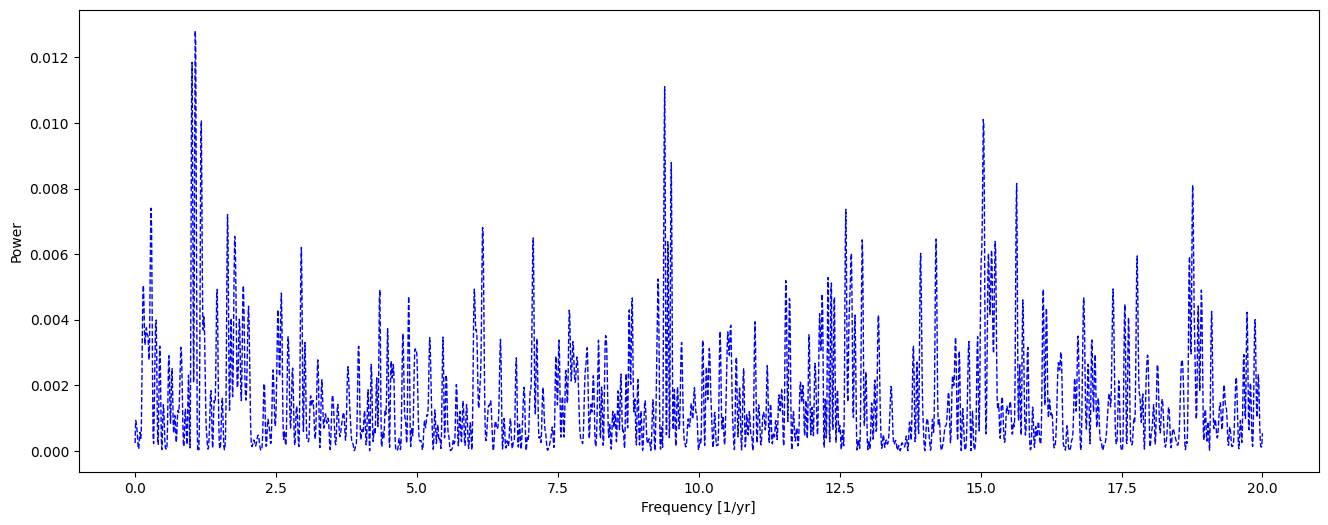

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(freq, power, '--', lw=1, c='b')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.show()

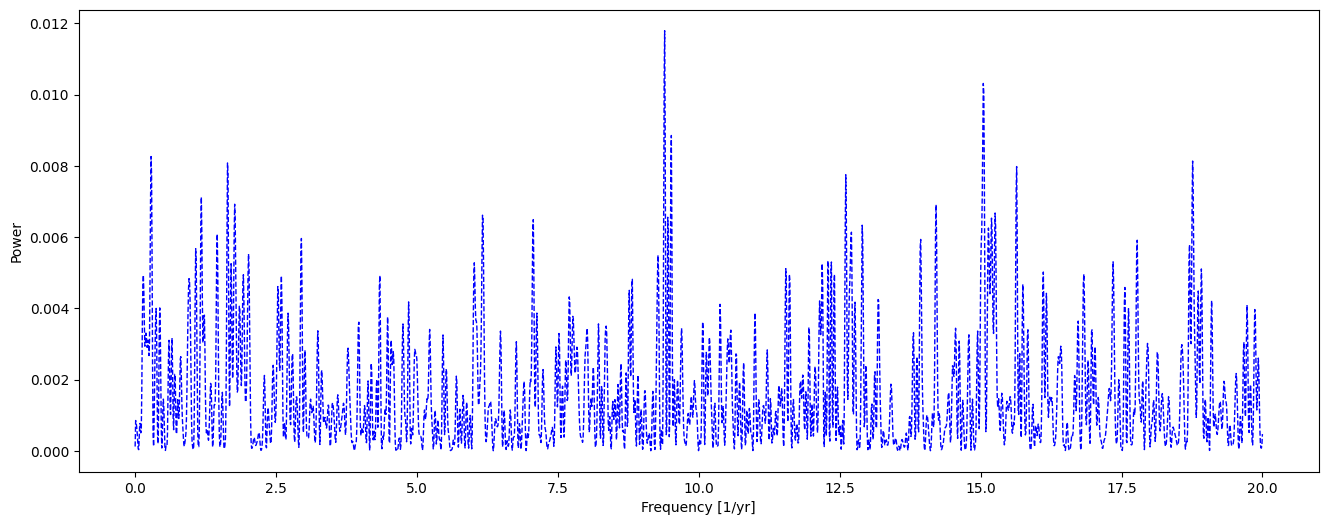

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(freq_d2, power_d2, '--', lw=1, c='b')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.show()

In [23]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

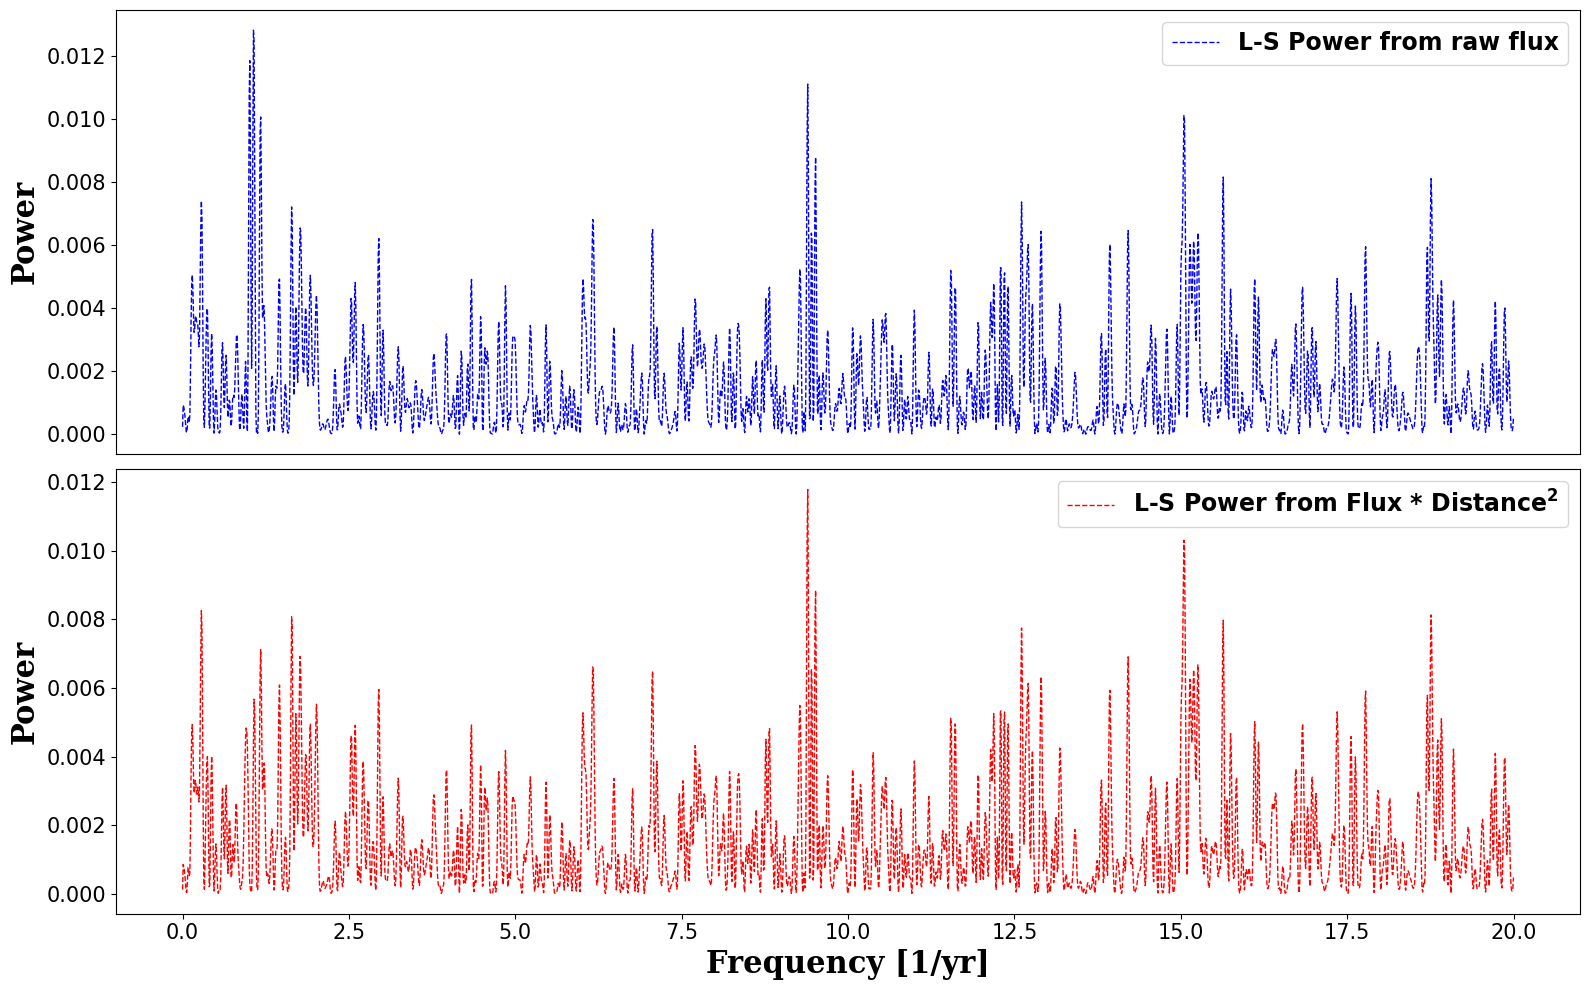

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq, power, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2, power_d2, '--', lw=1, c='r', label='L-S Power from Flux * Distance$\mathbf{^2}$')
# ax[1].set_title('Power from Flux * Distance^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})

ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('./outputs/ls_power.pdf', format='pdf')
plt.show()

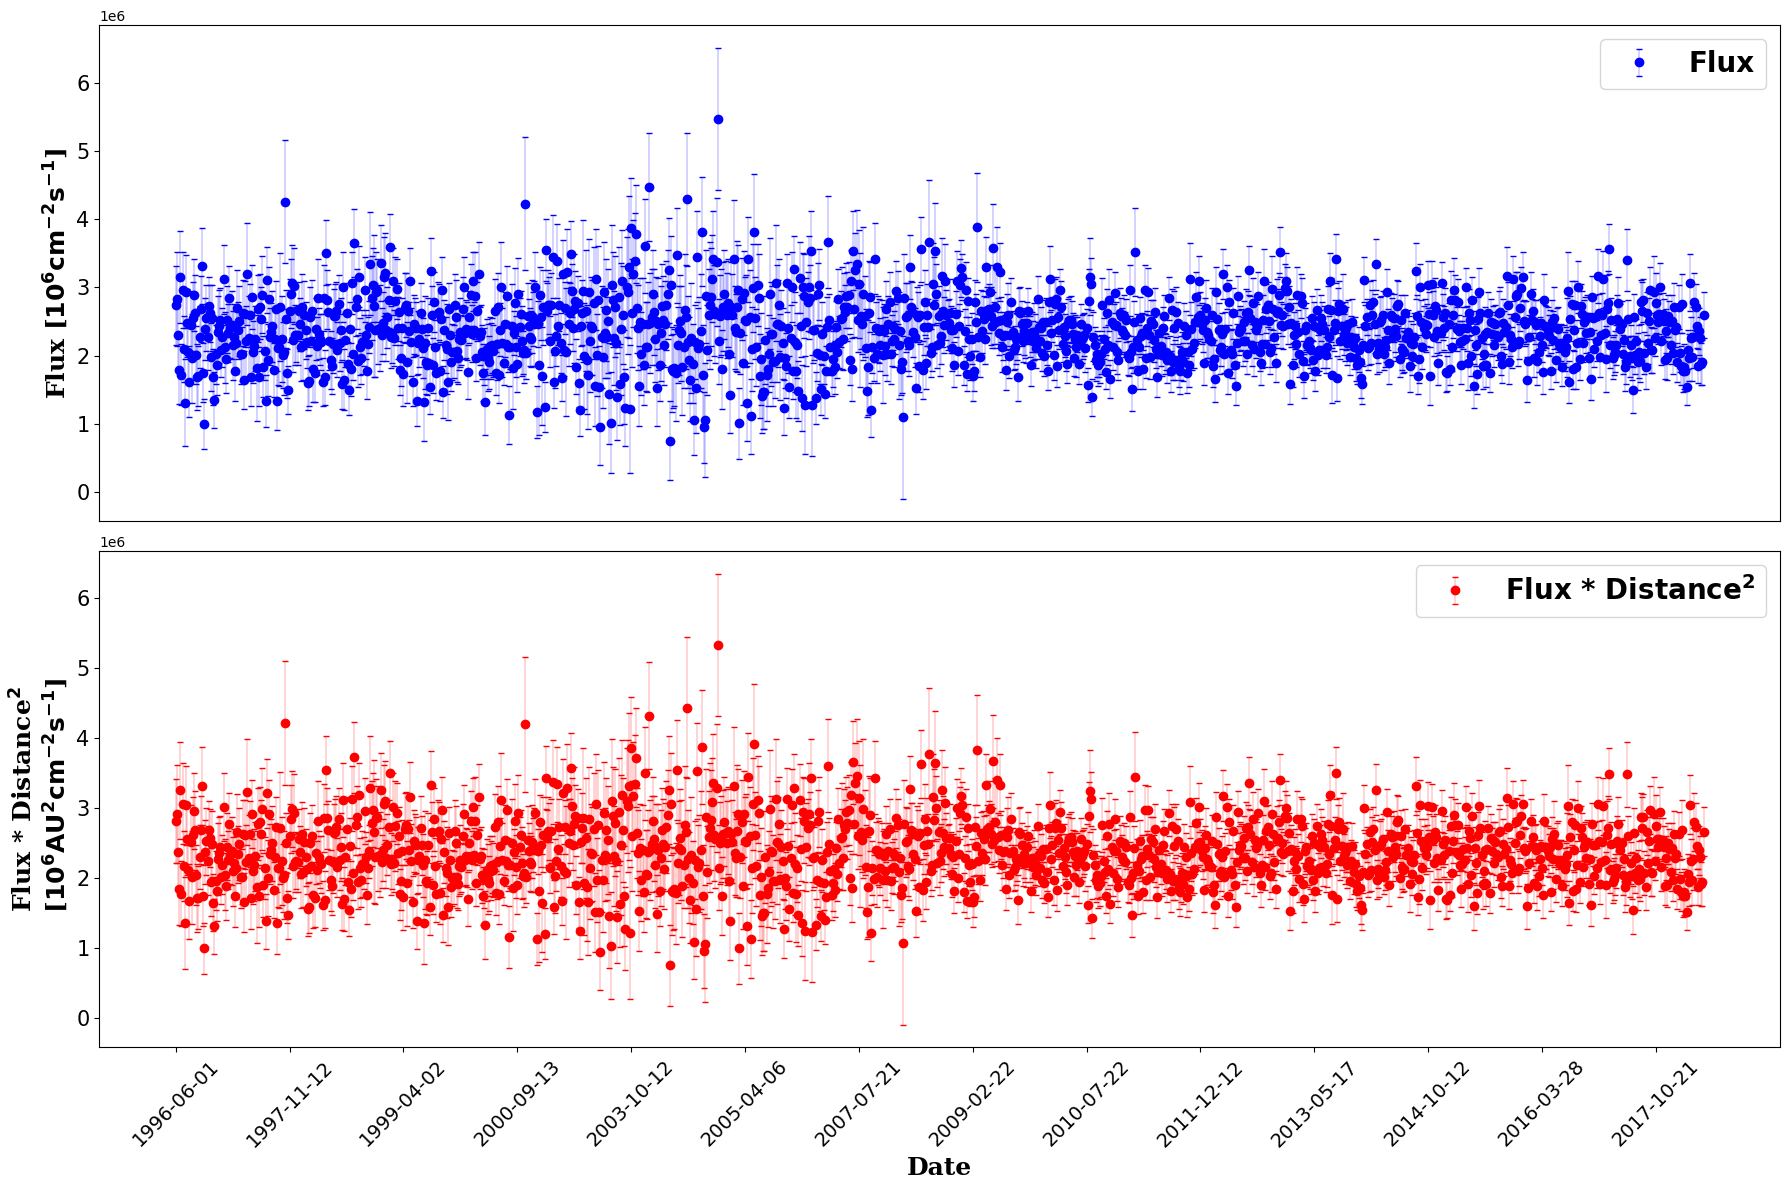

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }

ax[0].errorbar(t_mean_days, flux, yerr=0.5*(flux_err_up+flux_err_down), fmt='o', c='b', elinewidth=0.24, capsize=2, label='Flux')
ax[1].errorbar(t_mean_days, np.multiply(flux, avg_dists_2), yerr=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), fmt='o', c='r', elinewidth=0.24, capsize=2, label='Flux * Distance$\mathbf{^2}$')

ax[0].set_ylabel('Flux [$\mathbf{10^6 cm^{-2} s^{-1}}$]', fontdict=axesfont)


ax[1].set_ylabel('Flux * Distance$\mathbf{^2}$\n [$\mathbf{10^6 AU^{2} cm^{-2} s^{-1}}$]', fontdict=axesfont)

for i in range(2):
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':20, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Date',  fontdict=axesfont)
ax[1].set_xticks(t_mean_days[::100])
ax[1].xaxis.set_tick_params(labelsize=14, rotation=45)
plt.tight_layout()
plt.savefig('./outputs/timeseries.pdf')
plt.show()

In [42]:
top_num = 20
top4_power = np.sort(power)[-top_num:]
power_ind = np.argsort(power)[-top_num:]
top4_freq = freq[power_ind]

top4_power_d2 = np.sort(power_d2)[-top_num:]
power_d2_ind = np.argsort(power_d2)[-top_num:]
top4_freq_d2 = freq_d2[power_d2_ind]

In [43]:
# print(top4_freq)
# print(top4_power)
# print(lsp.false_alarm_probability(top4_power, method='bootstrap'))
# print(lsp.false_alarm_probability(top4_power, method='naive'))
# print(lsp.false_alarm_probability(top4_power, method='baluev'))

table1 = pd.DataFrame({'Frequency [1/yr]': top4_freq, 'Power': top4_power, 'FAP (Bootstrap)': lsp.false_alarm_probability(top4_power, method='bootstrap'), 'FAP (Naive)': lsp.false_alarm_probability(top4_power, method='naive'), 'FAP (Baluev)': lsp.false_alarm_probability(top4_power, method='baluev'), 'FAP (Davies)': lsp.false_alarm_probability(top4_power, method='davies')})

In [44]:
table1

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
0,9.503327,0.007813,1.000,1.000000,1.000000,41.498618
1,1.183364,0.008019,1.000,1.000000,1.000000,36.634328
2,18.760878,0.008105,1.000,1.000000,1.000000,34.760405
3,15.638616,0.008157,1.000,0.999999,1.000000,33.691165
4,1.083234,0.008348,1.000,0.999996,1.000000,29.982717
5,15.037831,0.008678,1.000,0.999956,1.000000,24.500976
6,9.403196,0.008741,1.000,0.999933,1.000000,23.572473
7,9.512430,0.008788,1.000,0.999911,1.000000,22.911775
8,1.019514,0.009016,1.000,0.999664,1.000000,19.916236
9,1.055925,0.009075,1.000,0.999541,1.000000,19.204482


In [45]:
table2 = pd.DataFrame({'Frequency [1/yr]': top4_freq_d2, 'Power': top4_power_d2, 'FAP (Bootstrap)': lsp_d2.false_alarm_probability(top4_power_d2, method='bootstrap'), 'FAP (Naive)': lsp_d2.false_alarm_probability(top4_power_d2, method='naive'), 'FAP (Baluev)': lsp_d2.false_alarm_probability(top4_power_d2, method='baluev'), 'FAP (Davies)': lsp_d2.false_alarm_probability(top4_power_d2, method='davies')})

In [46]:
table2

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
0,1.174262,0.007124,1.000,1.000000,1.000000,62.839224
1,15.028729,0.007186,1.000,1.000000,1.000000,60.564353
2,15.629514,0.007237,1.000,1.000000,1.000000,58.730803
3,18.769981,0.007408,1.000,1.000000,1.000000,52.980867
4,12.607383,0.007749,1.000,1.000000,1.000000,43.140999
5,1.647607,0.007756,1.000,1.000000,1.000000,42.955152
6,0.291290,0.007757,1.000,1.000000,1.000000,42.910650
7,15.065140,0.007831,1.000,1.000000,1.000000,41.051572
8,15.638616,0.007978,1.000,1.000000,1.000000,37.533053
9,9.503327,0.008009,1.000,1.000000,1.000000,36.834905


In [47]:
table1.to_latex('./outputs/table1.tex', index=False, float_format="%.5f")
table2.to_latex('./outputs/table2.tex', index=False, float_format="%.5f")

/tmp/ipykernel_11849/1147711091.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table1.to_latex('./outputs/table1.tex', index=False, float_format="%.5f")
/tmp/ipykernel_11849/1147711091.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2.to_latex('./outputs/table2.tex', index=False, float_format="%.5f")


In [70]:
freq_2x_coarse = np.linspace(1e-8/un.year, 20/un.year, int(10//np.diff(freq.value)[0]))
power_2x_coarse = lsp.power(freq_2x_coarse, normalization='log')

freq_d2_2x_coarse = np.linspace(1e-8/un.year, 20/un.year, int(10//np.diff(freq_d2)[0].value))
power_d2_2x_coarse = lsp_d2.power(freq_d2_2x_coarse, normalization='log')

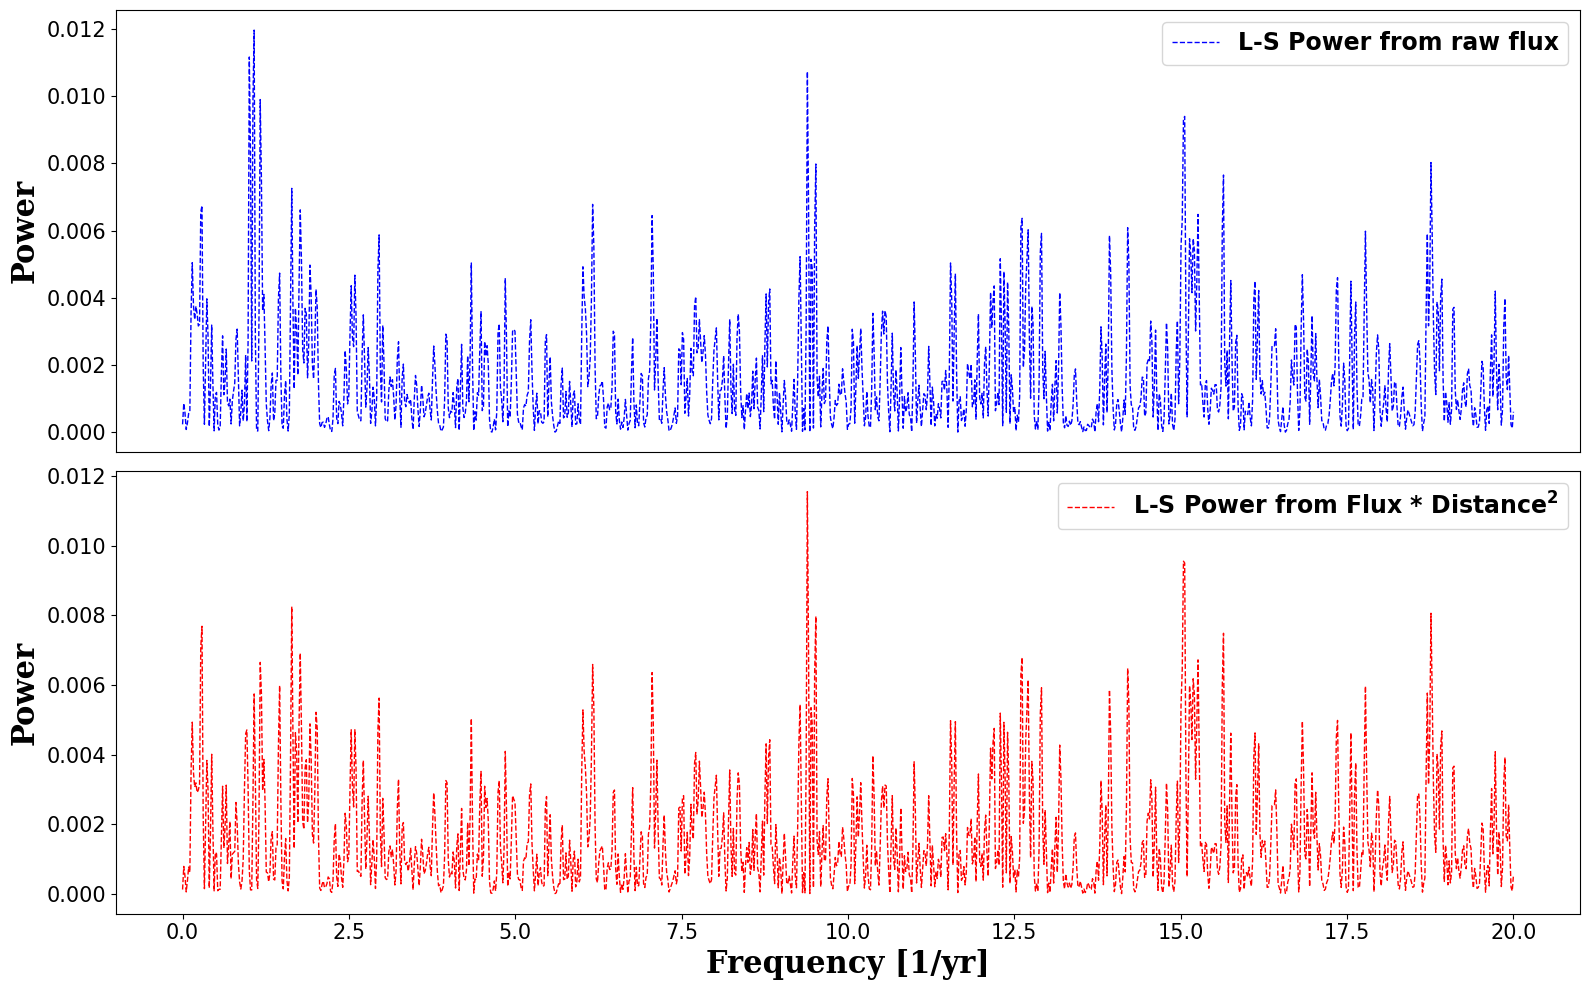

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq_2x_coarse, power_2x_coarse, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2_2x_coarse, power_d2_2x_coarse, '--', lw=1, c='r', label='L-S Power from Flux * Distance$\mathbf{^2}$')
# ax[1].set_title('Power from Flux * Distance^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('./outputs/ls_power_coarse.pdf', format='pdf')
plt.show()

In [74]:
freq_2x_coarse_max = freq_2x_coarse[np.nanargmax(power_2x_coarse)]
power_2x_coarse_max = power_2x_coarse[np.nanargmax(power_2x_coarse)]

freq_d2_2x_coarse_max = freq_d2_2x_coarse[np.nanargmax(power_d2_2x_coarse)]
power_d2_2x_coarse_max = power_d2_2x_coarse[np.nanargmax(power_d2_2x_coarse)]

In [75]:
print(freq_2x_coarse_max, power_2x_coarse_max)
print(freq_d2_2x_coarse_max, power_d2_2x_coarse_max)

1.0756609028076571 1 / yr 0.01197116579271871
9.389243396371924 1 / yr 0.011557909883281658


In [76]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='bootstrap'))

0.981
0.996


In [77]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='naive'))

0.6682729754563828
0.7667229527610033


In [78]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='baluev'))

0.958057818177457
0.9835685473689355


In [79]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='davies'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='davies'))

3.1714631783883362
4.108557843553695
